# Introduction

In [1]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from ipywidgets import *
from datetime import datetime, timedelta
from IPython.display import Image
from matplotlib.dates import DateFormatter

In [2]:
DATA_PATH = 'data/'
BTC_PATH = DATA_PATH + 'bitcoin/'
ETH_PATH = DATA_PATH + 'ethereum/'
HARDWARE_PATH = DATA_PATH+'hardware/'
FIG_PATH = '../../images/'

In [3]:
seconds_in_year = 31536000
hours_in_year = 8760
seconds_in_day = 86400
kWh_to_J = 3600*10**3
W_to_TWh = hours_in_year/(10**12)

std_PUE = {'lower': 1, 'estimate': 1.1, 'upper':1.2}
revenue_percent = 0.60

BTC_block_time = 600
BTC_difficulty_factor = 2**32

ETH_block_time = 15
ETH_difficulty_factor = 1


# Plots
date_form = DateFormatter("%m-%d")

In [4]:
def hashrate_from_difficulty(difficulty):
    return difficulty*BTC_difficulty_factor/BTC_block_time

## Geography 

In [5]:
# US: https://www.statista.com/statistics/190680/us-industrial-consumer-price-estimates-for-retail-electricity-since-1970/
# China: https://www.mondaq.com/china/oil-gas-electricity/804336/china-electricity-prices-for-industrial-consumers
# Russia: https://www.mondaq.com/china/oil-gas-electricity/804336/china-electricity-prices-for-industrial-consumers
# Kazakhstan: https://www.globalpetrolprices.com/Kazakhstan/electricity_prices/
# Malaysia: https://www.globalpetrolprices.com/Malaysia/electricity_prices/
# Iran: https://financialtribune.com/articles/energy/97278/rise-in-electricity-and-water-tariffs-in-iran

In [68]:
wet_months = [10,11,12,1,2,3,4]

In [31]:
data = {'location': ['China', 'US', 'Russia', 'Kazakhstan', 'Malaysia','Iran','Canada','Norway','Germany'],
        'share': [66.17, 7.15, 6.43, 5.89, 4.22, 3.67, 0.80, 0.67, 0.5],
        'price_wet': [0.035, 0.054, 0.041, 0.052, 0.01, 0.07, 0.058, 0.08, 0.2],
        'price_dry': [0.06, 0.054, 0.041, 0.052, 0.01, 0.07, 0.058, 0.08, 0.2],
        'renewable': [0.90, 0.69, 0.44, 0.12, 0.02, 0, 0.76, 0.99, 0.46]}
CBECI_geography = pd.DataFrame(data).set_index('location')
CBECI_geography['share'] = CBECI_geography['share']/100 
CBECI_geography['price_wet'] = CBECI_geography['price_wet']
CBECI_geography['price_dry'] = CBECI_geography['price_dry']
CBECI_geography.loc['RoW'] = [1-np.sum(CBECI_geography['share']), 0.084, 0.084, 0.26]

In [34]:
# https://docs.google.com/spreadsheets/d/1SWpxjoYNBVADs7Yc4x85bZvychc8GVXCJlI1lmMYT_4/edit#gid=1054902448
shares = [0.3649,0.0974,0.0822,0.055,0.015]
price_wet = [0.035,0.035,0.035,0.035,0.035]
price_dry = [0.06, 0.06,0.035,0.035,0.035]
renewable = [0.36, 0.90, 0.16, 0.70, 0.08]                                                                           

RoC_share = CBECI_geography.loc['China', 'share'] - np.sum(shares)
china_data = {'location': ['Xinjiang', 'Sichuan', 'Nei Mongol', 'Yunnan', 'Beijing'],
             'share': shares,
             'price_wet': price_wet,
             'price_dry': price_dry,
             'renewable': renewable}    
china_geography = pd.DataFrame(china_data).set_index('location')

china_geography.loc['RoC'] = [RoC_share, 0.035, 0.035, 0.47]

In [35]:
total_geography = CBECI_geography.append(china_geography).drop('China').sort_values(by='share', ascending=False)
total_geography

,share,price_wet,price_dry,renewable
location,,,,
Xinjiang,0.3649,0.035,0.060,0.36
Sichuan,0.0974,0.035,0.060,0.90
Nei Mongol,0.0822,0.035,0.035,0.16
US,0.0715,0.054,0.054,0.69
Russia,0.0643,0.041,0.041,0.44
Kazakhstan,0.0589,0.052,0.052,0.12
Yunnan,0.0550,0.035,0.035,0.70
RoC,0.0472,0.035,0.035,0.47
RoW,0.0450,0.084,0.084,0.26


In [57]:
avg_elec_price_wet = np.sum(total_geography.share*total_geography.price_wet)
avg_elec_price_dry = np.sum(total_geography.share*total_geography.price_dry)
avg_geography = pd.DataFrame({'share':1, 'wet_price':avg_elec_price_wet, 'dry_price':avg_elec_price_dry}, index=['world'])
avg_geography

,share,wet_price,dry_price
world,1,0.041491,0.053048


## Functions

In [60]:
def calc_profitability_threshold(data, PUE, elec_price, growth_factor):
    rev_per_hash = data['revenue']*growth_factor/data['hashrate'] #$/h
    return rev_per_hash/(elec_price*PUE)

def is_profitable(hardware, data, PUE, elec_price, growth_factor=1):
    profitability_threshold = calc_profitability_threshold(data, PUE, elec_price, growth_factor)
    # consumption is J/h, if smaller, more efficient
    if hardware['consumption'] < profitability_threshold:
        return True
    else:
        return False
    
def get_profitable_hardware(data, hardware, elec_price, PUE_dict = std_PUE, bound = 'estimate', PUE_fix = True, growth_factor = 1):
    if bound == "lower":
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['lower'], elec_price),axis=1)]
    elif bound == "upper":
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['upper'], elec_price),axis=1)]
    else:
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['estimate'], elec_price),axis=1)]
    if prof_hardware.empty and PUE_fix:
        prof_hardware = hardware[hardware.consumption == hardware.consumption.min()]
    return prof_hardware

In [38]:
def get_buy_hardware(hardware):
    return hardware.sort_values(by='consumption').iloc[0]

def get_turn_on_hardware(hardware):
    return hardware.sort_values(by='consumption').iloc[0]

def get_turn_off_hardware(hardware): 
    return hardware.sort_values(by='consumption', ascending=False).iloc[0]

In [39]:
def calc_consumption(hardware):
    # TODO: bounds
    return np.sum(hardware['on_num']*hardware['hashing_power']*hardware['consumption'])

In [193]:
def replace_hardware(time, data, hardware, elec_price, share=0.01):
    """
    Replace 1% of hashrate each iteration
    """ 
    # Next hardware
    cur_hardware = hardware[hardware.release_date < time]
    prof_hardware = get_profitable_hardware(data, cur_hardware, elec_price)
    best_hardware = get_buy_hardware(prof_hardware)

    hashrate_share = data.hashrate*share
    total_replaced_hashrate = 0 
    
    while total_replaced_hashrate < hashrate_share:
        on_hardware = hardware[hardware['on_num'] >= 1]  
        to_replace_hardware = get_turn_off_hardware(on_hardware)
        
        num_to_off = np.ceil(min(hashrate_share/to_replace_hardware.hashing_power, to_replace_hardware.on_num))     
        hardware.loc[to_replace_hardware.name, 'on_num'] -= num_to_off
        hardware.loc[to_replace_hardware.name, 'off_num'] += num_to_off
        
        cur_replaced_hashrate = num_to_off*to_replace_hardware.hashing_power
        num_extra = np.ceil(cur_replaced_hashrate/best_hardware.hashing_power)
        hardware.loc[best_hardware.name, 'on_num'] += num_extra
        
        total_replaced_hashrate += cur_replaced_hashrate

    return hardware

In [171]:
hardware.loc[get_turn_on_hardware(hardware).name]

name             Bitmain Antminer S19 Pro (110Th)
release_date                  2020-05-01 00:00:00
consumption                             2.955e-11
hashing_power                             1.1e+14
efficiency                            3.38409e+10
off_num                                         0
on_num                                          0
Name: 82, dtype: object

# Bitcoin

## Loading history

In [352]:
# https://www.blockchain.com/charts/difficulty
difficulty = pd.read_csv(BTC_PATH+'difficulty.csv')
# https://www.blockchain.com/charts/miners-revenue
revenue = pd.read_csv(BTC_PATH+'miners-revenue.csv')
# https://www.blockchain.com/charts/market-price
price = pd.read_csv(BTC_PATH+'price.csv')

difficulty['Timestamp'] = pd.to_datetime(difficulty['Timestamp'])
revenue['Timestamp'] = pd.to_datetime(revenue['Timestamp'])
price['Timestamp'] = pd.to_datetime(price['Timestamp'])

difficulty = difficulty.rename(columns={'Timestamp': 'timestamp'}).set_index('timestamp')
revenue = revenue.rename(columns={'Timestamp': 'timestamp', 'miners-revenue': 'revenue'}).set_index('timestamp')
price = price.rename(columns={'Timestamp': 'timestamp', 'market-price': 'price'}).set_index('timestamp')

In [353]:
revenue = revenue.groupby(pd.Grouper(freq='W')).mean()
revenue = revenue/seconds_in_day
difficulty = difficulty.groupby(pd.Grouper(freq='W')).mean()
bitcoin = difficulty.join(revenue).dropna()

In [354]:
price = price.groupby(pd.Grouper(freq='W')).mean()
bitcoin = bitcoin.join(price).dropna()
bitcoin

,difficulty,revenue,price
timestamp,,,
2009-01-25,1.000000e+00,0.000000,0.000000
2009-02-01,1.000000e+00,0.000000,0.000000
2009-02-08,1.000000e+00,0.000000,0.000000
2009-02-15,1.000000e+00,0.000000,0.000000
2009-02-22,1.000000e+00,0.000000,0.000000
...,...,...,...
2020-04-19,1.471520e+13,164.153155,6967.716429
2020-04-26,1.595870e+13,155.823463,7017.877143
2020-05-03,1.595870e+13,164.896564,7640.203810


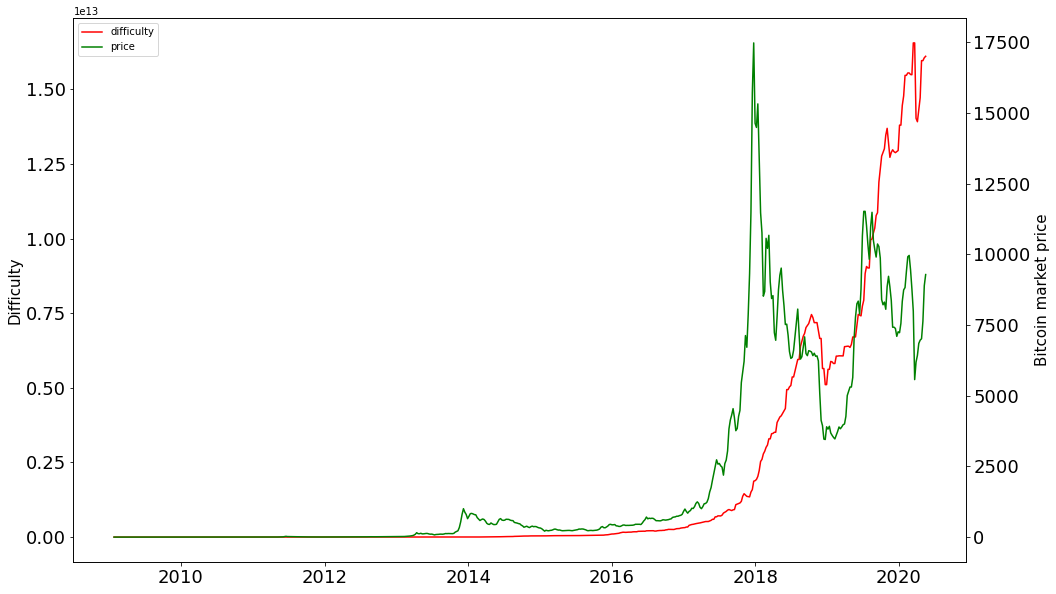

In [355]:
fig, ax1 = plt.subplots(figsize=(16,10))

ln1 = ax1.plot(bitcoin['difficulty'],color="red", label="difficulty")

ax2 = ax1.twinx()

ln2 = ax2.plot(bitcoin['price'], color="green", label="price")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

#ax2.legend(loc='upper left')

ax1.set_ylabel('Difficulty', fontsize = 15)
ax2.set_ylabel('Bitcoin market price', fontsize = 15)

ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

plt.show()

In [356]:
first_halve = datetime(2012, 11, 1)
second_halve = datetime(2016, 7, 1)
third_halve = datetime(2020, 5, 13)


asic = datetime(2013,1,1)
gpu = datetime(2010,10,1)
fpga = datetime(2011, 6, 1)

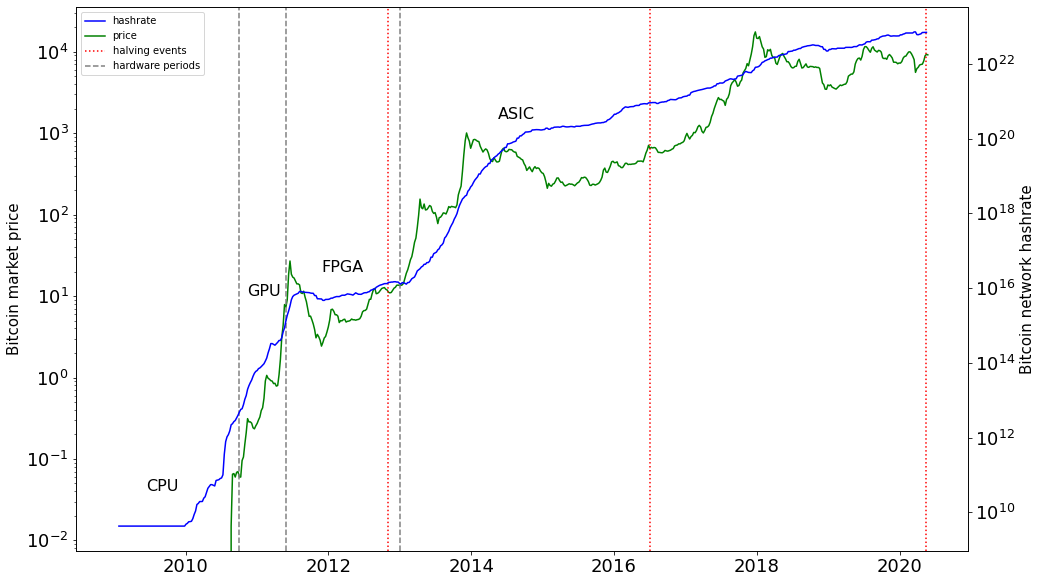

In [357]:
fig, ax = plt.subplots(figsize=(16,10))

ln1 = ax.plot(price['price'], color="green", label="price")
#plt.plot(first_halve)

ax2 = ax.twinx()
ln1 = ax2.plot(bitcoin['difficulty']*2**32,color="blue", label="hashrate")

h1 = ax.axvline(first_halve, color='red', label='halving events', ls=':')
ax.axvline(second_halve, color='red', ls=':')
ax.axvline(third_halve, color='red', ls=':')

h2 = ax.axvline(gpu, color='grey', label='hardware periods', ls='--')
ax.axvline(fpga, color='grey', ls='--')
ax.axvline(asic, color='grey', ls='--')

ax.text(datetime(2009,6,15),0.04, 'CPU', fontsize=16)
ax.text(gpu + timedelta(days=40),10, 'GPU', fontsize=16)
ax.text(fpga + timedelta(days=180),20, 'FPGA', fontsize=16)
ax.text(asic + timedelta(days=500),1500, 'ASIC', fontsize=16)


ln3 = [h1, h2]

ax.set_yscale('log')
ax2.set_yscale('log')

# added these three lines
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

ax.set_ylabel('Bitcoin market price', fontsize = 15)
ax2.set_ylabel('Bitcoin network hashrate', fontsize = 15)
plt.savefig(FIG_PATH+'BTC_hashrate_price.png')
plt.show()

## Simulate

In [598]:
SHA256_hardware = pd.read_csv(HARDWARE_PATH+'SHA256_hardware_clean.csv',index_col=0)
# Initialisation
hardware = SHA256_hardware[['name', 'release_date', 'consumption', 'hashing_power']].copy()
hardware['release_date'] = pd.to_datetime(hardware['release_date'])
hardware['efficiency'] = 1/hardware['consumption']
hardware.loc[0, 'hashing_power'] = 478*(10**9)
hardware.sort_values(by='consumption')

,name,release_date,consumption,hashing_power,efficiency
82,Bitmain Antminer S19 Pro (110Th),2020-05-01,2.955000e-11,1.100000e+14,3.384095e+10
83,Bitmain Antminer S19 (95Th),2020-05-01,3.421000e-11,9.500000e+13,2.923122e+10
80,MicroBT Whatsminer M30S,2020-04-01,3.800000e-11,8.600000e+13,2.631579e+10
57,Bitmain Antminer S17 Pro (50Th),2019-04-01,3.950000e-11,5.000000e+13,2.531646e+10
56,Bitmain Antminer S17 Pro (53Th),2019-04-01,3.951000e-11,5.300000e+13,2.531005e+10
...,...,...,...,...,...
22,Bitmain Antminer V9 (4Th),2018-03-01,2.567500e-10,4.000000e+12,3.894839e+09
4,Bitmain Antminer S7-LN,2016-06-01,2.581500e-10,3.000000e+12,3.873717e+09
2,Bitmain Antminer S7,2015-09-01,2.733600e-10,5.000000e+12,3.658180e+09
1,Bitmain Antminer S5,2014-12-01,5.108200e-10,1.000000e+12,1.957637e+09


In [384]:
# Select only from first hardware available in dataset
bitcoin = bitcoin[bitcoin.index > SHA256_hardware.loc[0,'release_date']].copy()

# Difficulty to hashrate
bitcoin['hashrate'] = bitcoin['difficulty'].apply(lambda x: hashrate_from_difficulty(x))

In [385]:
# TODO: make function with 'until'

hardware['off_num'] = 0
hardware['on_num'] = 0

cur_hashrate = 0
consumption = []
consumption_lower = []
for time, data in bitcoin.iterrows():
    cur_hardware = hardware[hardware.release_date < time]
    hashrate_difference = data.hashrate - cur_hashrate
    
    if time.month in wet_months:
        elec_price = avg_elec_price_wet
    else:
        elec_price = avg_elec_price_dry
        
    if hashrate_difference > 0:
        # Network hashrate has increased, turn on/buy devices
        prof_hardware = get_profitable_hardware(data, cur_hardware, elec_price)
        off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
                
        while cur_hashrate < data.hashrate and (not off_hardware.empty):
            
            best_off_hardware = get_turn_on_hardware(off_hardware)
            
            # Everything gets turned on OR the part needed for hashrate difference gets turned on
            extra_hashing_power = min(best_off_hardware.off_num*best_off_hardware.hashing_power, hashrate_difference)
            
            num_to_on = extra_hashing_power/best_off_hardware.hashing_power
            
            hardware.loc[best_off_hardware.name, 'on_num'] += num_to_on
            hardware.loc[best_off_hardware.name, 'off_num'] -= num_to_on
            
            cur_hashrate += extra_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
            
        if off_hardware.empty and cur_hashrate < data.hashrate:
            # Have to buy new hardware. Buy entire difference in hashrate from get_next_hardware
            best_hardware = get_buy_hardware(prof_hardware)
            
            num_extra = np.ceil(hashrate_difference/best_hardware.hashing_power)
            
            hardware.loc[best_hardware.name, 'on_num'] += num_extra
            
            cur_hashrate += num_extra*best_hardware.hashing_power
                
    elif hashrate_difference < 0:
        # Network hashrate has decreased, turn off devices
        on_hardware = hardware[hardware['on_num'] >= 1]
        while cur_hashrate > data.hashrate:            
            worst_on_hardware = get_turn_off_hardware(on_hardware)
        
            min_hashing_power = min(worst_on_hardware.on_num*worst_on_hardware.hashing_power, -hashrate_difference)
            
            num_to_off = np.floor(min_hashing_power/worst_on_hardware.hashing_power)
            
            hardware.loc[worst_on_hardware.name, 'on_num'] -= num_to_off
            hardware.loc[worst_on_hardware.name, 'off_num'] += num_to_off
            
            cur_hashrate -= min_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            on_hardware = hardware[hardware['on_num'] >= 1]
    else:
        #print('hashrate_difference = 0')
        pass
    hardware = replace_hardware(time, data, hardware, elec_price, share=0.01)
    cur_hashrate = np.sum(hardware['on_num']*hardware['hashing_power'])
    consumption.append(calc_consumption(hardware)*W_to_TWh)  
    
    best_hardware = get_buy_hardware(cur_hardware)
    consumption_lower.append(cur_hashrate*best_hardware.consumption*W_to_TWh)
    
bitcoin['consumption'] = consumption
bitcoin['consumption_lower'] = consumption_lower

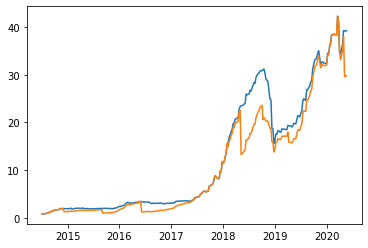

In [386]:
plt.plot(bitcoin.index,bitcoin.consumption)
plt.plot(bitcoin.index,bitcoin.consumption_lower)
plt.show()

In [387]:
# Last year
used_hardware = hardware[(hardware['on_num'] > 0) | (hardware['off_num'] > 0)].copy()
used_hardware[['off_num', 'on_num']] = used_hardware[['off_num', 'on_num']].astype(int)
used_hardware = used_hardware.set_index('name',drop=True)
used_hardware.loc['Bitmain Antminer S3', 'weight'] = 5.2
used_hardware.loc['Bitmain Antminer S5', 'weight'] = 2.5
used_hardware.loc['Bitmain Antminer S7', 'weight'] = 3.9
used_hardware.loc['Bitmain Antminer S9 (11.5Th)', 'weight'] = 4.2
used_hardware.loc['Bitmain Antminer R4', 'weight'] = 2.5
used_hardware.loc['Ebang Ebit E10', 'weight'] = 9.8
used_hardware.loc['ASICminer 8 Nano Pro', 'weight'] = 68
used_hardware.loc['Ebang Ebit E11++', 'weight'] = 10
used_hardware.loc['Bitmain Antminer S17 Pro (50Th)', 'weight'] = 9.5
#used_hardware.loc['MicroBT Whatsminer M30S', 'weight'] = 10.5
#used_hardware.loc['Bitmain Antminer S19 Pro (110Th)', 'weight'] = 13.2
used_hardware['consumption'] = used_hardware['consumption'].map('{:,.2E}'.format)
# used_hardware['hashing_power'] = used_hardware['hashing_power'].map('{:,.2E}'.format)
used_hardware = used_hardware.drop(columns=['hashing_power', 'efficiency'])
used_hardware

,release_date,consumption,off_num,on_num,weight
name,,,,,
Bitmain Antminer S3,2014-07-01,7.66E-10,628218,0,5.2
Bitmain Antminer S5,2014-12-01,5.11E-10,285369,0,2.5
Bitmain Antminer S7,2015-09-01,2.73E-10,279086,0,3.9
Bitmain Antminer S9 (11.5Th),2016-06-01,9.80E-11,180751,0,4.2
Bitmain Antminer R4,2017-02-01,9.71E-11,2051590,0,2.5
Ebang Ebit E10,2018-02-01,9.17E-11,717105,0,9.8
ASICminer 8 Nano Pro,2018-05-01,5.26E-11,408148,0,68.0
Ebang Ebit E11++,2018-10-01,4.50E-11,575019,0,10.0
Bitmain Antminer S17 Pro (50Th),2019-04-01,3.95E-11,673891,1838572,9.5


In [388]:
np.sum(used_hardware['off_num']) + np.sum(used_hardware['on_num'])

7897917

In [389]:
np.sum(used_hardware['off_num']) + np.sum(used_hardware['on_num'])

7897917

In [390]:
used_hardware = hardware[(hardware['on_num'] > 0) | (hardware['off_num'] > 0)].copy()
used_hardware[['off_num', 'on_num']] = used_hardware[['off_num', 'on_num']].astype(int)
used_hardware = used_hardware.set_index('name',drop=True)

In [391]:
used_hardware.loc['Bitmain Antminer S3', 'weight'] = 5.2
used_hardware.loc['Bitmain Antminer S5', 'weight'] = 2.5
used_hardware.loc['Bitmain Antminer S7', 'weight'] = 3.9
used_hardware.loc['Bitmain Antminer S9 (11.5Th)', 'weight'] = 4.2
used_hardware.loc['Bitmain Antminer R4', 'weight'] = 2.5
used_hardware.loc['Ebang Ebit E10', 'weight'] = 9.8
used_hardware.loc['ASICminer 8 Nano Pro', 'weight'] = 68
used_hardware.loc['Ebang Ebit E11++', 'weight'] = 10
used_hardware.loc['Bitmain Antminer S17 Pro (50Th)', 'weight'] = 9.5
used_hardware.loc['MicroBT Whatsminer M30S', 'weight'] = 10.5
used_hardware.loc['Bitmain Antminer S19 Pro (110Th)', 'weight'] = 13.2
used_hardware['consumption'] = used_hardware['consumption'].map('{:,.2E}'.format)
# used_hardware['hashing_power'] = used_hardware['hashing_power'].map('{:,.2E}'.format)
used_hardware = used_hardware.drop(columns=['hashing_power', 'efficiency'])
used_hardware

,release_date,consumption,off_num,on_num,weight
name,,,,,
Bitmain Antminer S3,2014-07-01,7.66E-10,628218,0,5.2
Bitmain Antminer S5,2014-12-01,5.11E-10,285369,0,2.5
Bitmain Antminer S7,2015-09-01,2.73E-10,279086,0,3.9
Bitmain Antminer S9 (11.5Th),2016-06-01,9.80E-11,180751,0,4.2
Bitmain Antminer R4,2017-02-01,9.71E-11,2051590,0,2.5
Ebang Ebit E10,2018-02-01,9.17E-11,717105,0,9.8
ASICminer 8 Nano Pro,2018-05-01,5.26E-11,408148,0,68.0
Ebang Ebit E11++,2018-10-01,4.50E-11,575019,0,10.0
Bitmain Antminer S17 Pro (50Th),2019-04-01,3.95E-11,673891,1838572,9.5


In [392]:
np.sum(used_hardware['off_num']*used_hardware['weight'])/10**3

57890.5682

In [393]:
np.sum(used_hardware['on_num']*used_hardware['weight'])/10**3

20308.420100000003

In [394]:
print(used_hardware.to_latex())

\begin{tabular}{lllrrr}
\toprule
{} & release\_date & consumption &  off\_num &   on\_num &  weight \\
name                             &              &             &          &          &         \\
\midrule
Bitmain Antminer S3              &   2014-07-01 &    7.66E-10 &   628218 &        0 &     5.2 \\
Bitmain Antminer S5              &   2014-12-01 &    5.11E-10 &   285369 &        0 &     2.5 \\
Bitmain Antminer S7              &   2015-09-01 &    2.73E-10 &   279086 &        0 &     3.9 \\
Bitmain Antminer S9 (11.5Th)     &   2016-06-01 &    9.80E-11 &   180751 &        0 &     4.2 \\
Bitmain Antminer R4              &   2017-02-01 &    9.71E-11 &  2051590 &        0 &     2.5 \\
Ebang Ebit E10                   &   2018-02-01 &    9.17E-11 &   717105 &        0 &     9.8 \\
ASICminer 8 Nano Pro             &   2018-05-01 &    5.26E-11 &   408148 &        0 &    68.0 \\
Ebang Ebit E11++                 &   2018-10-01 &    4.50E-11 &   575019 &        0 &    10.0 \\
Bitmain Antmine

In [395]:
bitcoin.iloc[len(bitcoin)-1].hashrate

1.1528264884770133e+20

In [396]:
np.sum(hardware['on_num']*hardware['hashing_power'])

1.1528279963981093e+20

## Extrapolation

In [397]:
import matplotlib.dates as mdates

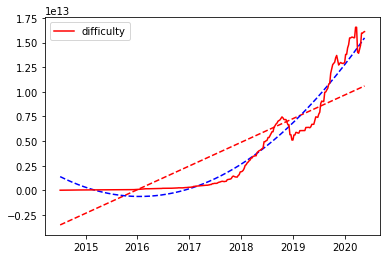

In [398]:
x = mdates.date2num(bitcoin.index)

z = np.polyfit(x,bitcoin['difficulty'], 1)

p = np.poly1d(z)
plt.plot(x,p(x),"r--")

z2 = np.polyfit(x,bitcoin['difficulty'], 2)
p2 = np.poly1d(z2)
plt.plot(x,p2(x),"b--")

plt.plot(bitcoin['difficulty'],color="red", label="difficulty")
plt.legend()
plt.show()

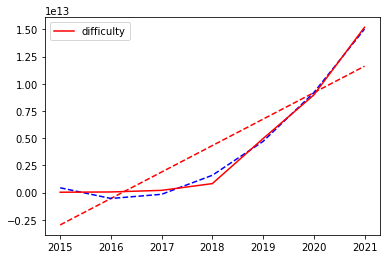

In [399]:
bitcoin_year = bitcoin.groupby(pd.Grouper(freq='Y')).mean()
x = mdates.date2num(bitcoin_year.index)

z = np.polyfit(x,bitcoin_year['difficulty'], 1)

p = np.poly1d(z)
plt.plot(x,p(x),"r--")

z2 = np.polyfit(x,bitcoin_year['difficulty'], 2)
p2 = np.poly1d(z2)
plt.plot(x,p2(x),"b--")

plt.plot(bitcoin_year['difficulty'],color="red", label="difficulty")
plt.legend()
plt.show()

In [400]:
for i in range(len(bitcoin_year)):
    print(bitcoin_year.iloc[i]['hashrate']/bitcoin_year.iloc[i-1]['hashrate'])

0.0019861852921524694
1.7872380320308643
3.744803846524828
4.071251007947607
6.027620036927426
1.8074622793840696
1.6959997232768518


In [401]:
bitcoin

,difficulty,revenue,price,hashrate,consumption,consumption_lower,hashrate_pred,consumption_pred
timestamp,,,,,,,,
2014-07-06,1.681846e+10,33.373953,598.955714,1.203912e+17,0.807519,0.807519,3.083778e+16,0.206843
2014-07-13,1.681846e+10,31.709518,631.147619,1.203912e+17,0.807519,0.807519,7.040629e+16,0.472246
2014-07-20,1.733632e+10,33.226293,626.760000,1.240982e+17,0.848535,0.848535,1.075644e+17,0.721482
2014-07-27,1.780303e+10,33.381070,625.332143,1.274390e+17,0.854790,0.854790,1.448811e+17,0.971782
2014-08-03,1.873644e+10,31.599697,599.566667,1.341207e+17,0.910232,0.910232,1.749257e+17,1.173304
...,...,...,...,...,...,...,...,...
2020-04-19,1.471520e+13,164.153155,6967.716429,1.053355e+20,36.332312,35.064098,6.337726e+19,21.097024
2020-04-26,1.595870e+13,155.823463,7017.877143,1.142368e+20,39.280388,38.027186,6.404429e+19,21.319063
2020-05-03,1.595870e+13,164.896564,7640.203810,1.142368e+20,39.180812,29.571143,6.995303e+19,18.107901


### Consumption

In [402]:
# Koomey's law
start_hardware = hardware.loc[0]
efficiency = 0
intervals = 0
for i in range(6):
    cur_hardware = hardware.loc[i]
    efficiency += cur_hardware.efficiency
    intervals += (cur_hardware.release_date-start_hardware.release_date).days

In [403]:
intervals = intervals/6
efficiency = efficiency/6

In [404]:
start_date = start_hardware.release_date+timedelta(days=intervals)

In [405]:
"""
Average over first hardware
"""
def n(t, efficiency, start_date):
    n_0 = efficiency
    t_delta = (t - start_date).days/365
    return n_0*(1.27**t_delta)
# Create date
days_future = 365*6
base = start_hardware.release_date
date_list = [base + timedelta(days=x) for x in range(days_future)]
hardware_consumption_pred = list(map(lambda x: n(x, efficiency, start_date), date_list))

In [406]:
# Koomey's law
start_hardware = hardware.loc[3]
def n(start_hardware, t):
    n_0 = start_hardware.efficiency
    start_date = start_hardware.release_date
    t_delta = (t - start_date).days/365
    return n_0*(1.27**t_delta)

# Create date
days_future = 365*4
base = start_hardware.release_date
date_list = [base + timedelta(days=x) for x in range(days_future)]
hardware_consumption_pred = list(map(lambda x: n(start_hardware, x), date_list))

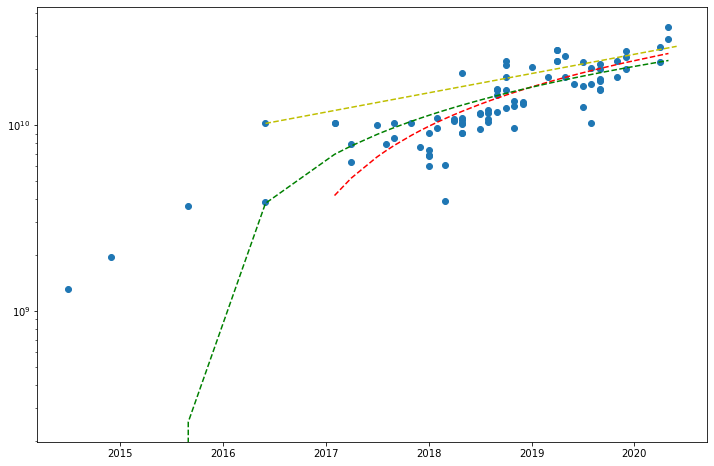

In [407]:
outliers = True
plt.figure(figsize=(12,8))

hardware_new = hardware[hardware.release_date > datetime(2017,1,1)]

x = mdates.date2num(hardware_new.release_date)
z = np.polyfit(x, hardware_new['efficiency'], 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.plot(date_list, hardware_consumption_pred, "y--")

if outliers:
    x2 = mdates.date2num(hardware.release_date)
    z2 = np.polyfit(x2,hardware['efficiency'], 1)
    p2 = np.poly1d(z2)
    plt.plot(x2,p2(x2),"g--")
    plt.scatter(hardware['release_date'], hardware['efficiency'])
else :
    plt.scatter(hardware_new['release_date'], hardware_new['efficiency'])
plt.yscale('log')
plt.show()

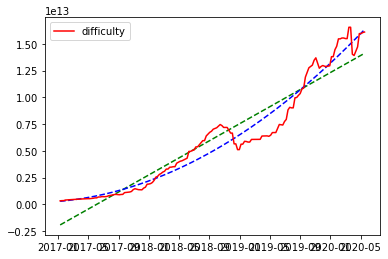

In [408]:
bitcoin_new = bitcoin[bitcoin.index > datetime(2017,1,1)]

x = mdates.date2num(bitcoin_new.index)
z = np.polyfit(x,bitcoin_new['difficulty'], 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g--")

z2 = np.polyfit(x,bitcoin_new['difficulty'], 2)
p2 = np.poly1d(z2)
plt.plot(x,p2(x),"b--")

plt.plot(bitcoin_new['difficulty'],color="red", label="difficulty")
plt.legend()
plt.show()

In [409]:
bitmain = hardware[hardware['name'].apply(lambda x: 'Bitmain' in x or 'Antminer' in x)]

### Hashrate vs efficienty gain

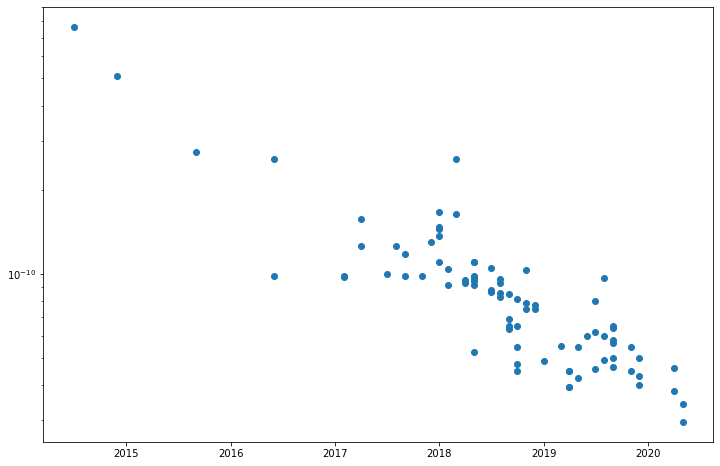

In [410]:
plt.figure(figsize=(12,8))
plt.scatter(hardware['release_date'], hardware['consumption'])
plt.yscale('log')
plt.show()

In [411]:
def get_most_efficient(hardware, before):
    hardware = hardware[hardware.release_date < before]
    return hardware.sort_values(by='consumption').iloc[0]['consumption']

In [412]:
bitcoin['hardware_consumption'] = bitcoin.apply(lambda x: get_most_efficient(hardware, x.name), axis=1)

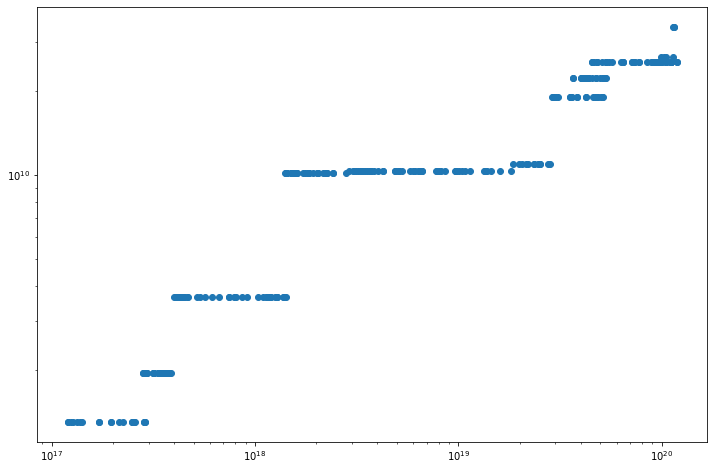

In [413]:
plt.figure(figsize=(12,8))
plt.scatter(bitcoin['hashrate'], 1/bitcoin['hardware_consumption'])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [414]:
def to_end_of_week(date):
    return date-timedelta(days=date.weekday())+ timedelta(days=6)

# To end of week like bitcoin
hardware['release_date'] = hardware['release_date'].apply(lambda x: to_end_of_week(x))
# Add hashrate on release day
hardware['cur_hashrate'] = hardware['release_date'].apply(lambda x: bitcoin.loc[x, 'hashrate'])
hardware

,name,release_date,consumption,hashing_power,efficiency,off_num,on_num,cur_hashrate
0,Bitmain Antminer S3,2014-07-06,7.656900e-10,4.780000e+11,1.306012e+09,628218.753534,-0.753534,1.203912e+17
1,Bitmain Antminer S5,2014-12-07,5.108200e-10,1.000000e+12,1.957637e+09,285369.000000,0.000000,2.874317e+17
2,Bitmain Antminer S7,2015-09-06,2.733600e-10,5.000000e+12,3.658180e+09,279086.000000,0.000000,3.980514e+17
3,Bitmain Antminer S9 (11.5Th),2016-06-05,9.800000e-11,1.200000e+13,1.020408e+10,180751.000000,0.000000,1.426731e+18
4,Bitmain Antminer S7-LN,2016-06-05,2.581500e-10,3.000000e+12,3.873717e+09,0.000000,0.000000,1.426731e+18
...,...,...,...,...,...,...,...,...
79,ASICminer 8 Nano S 58Th,2019-12-01,4.310000e-11,5.800000e+13,2.320186e+10,0.000000,0.000000,9.286578e+19
80,MicroBT Whatsminer M30S,2020-04-05,3.800000e-11,8.600000e+13,2.631579e+10,0.000000,219345.000000,9.958955e+19
81,MicroBT Whatsminer M31S,2020-04-05,4.600000e-11,7.000000e+13,2.173913e+10,0.000000,0.000000,9.958955e+19
82,Bitmain Antminer S19 Pro (110Th),2020-05-03,2.955000e-11,1.100000e+14,3.384095e+10,0.000000,40823.000000,1.142368e+20


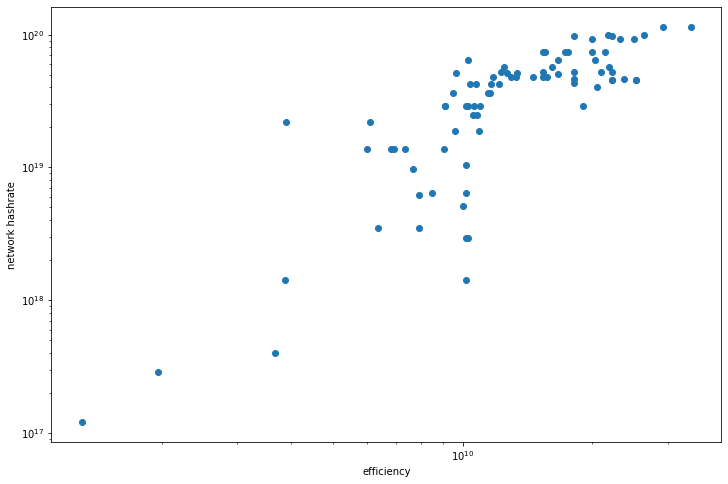

In [415]:
plt.figure(figsize=(12,8))
plt.scatter(1/hardware['consumption'], hardware['cur_hashrate'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('efficiency')
plt.ylabel('network hashrate')
plt.show()

## Hashrate predictor

We start from moment that first ASICs came into existence 

In [416]:
from dateutil.relativedelta import relativedelta

In [430]:
startdate = hardware.loc[0, 'release_date'] - timedelta(days=1)
startdate

Timestamp('2014-07-05 00:00:00')

In [637]:
# consumption
def n(t):
    cur_hardware = hardware[hardware.release_date <= t]
    best_hardware = cur_hardware.sort_values(by='consumption').iloc[0]
    year_delta = (t - best_hardware.release_date).days/365
    if year_delta == 0:
        return best_hardware.consumption
    return best_hardware.consumption/(1.27**year_delta)
# n(datetime(2020,5,20))

In [638]:
def gamma(t):
    rew0 = 25
    second_halve = datetime(2016,7,1) 
    if t < second_halve:
        return rew0
    else:
        year_delta = (t - second_halve).days/365
        rew = rew0/2**(np.floor(year_delta/4)+1)
        return rew
#gamma(datetime(2020,8,13))

In [639]:
def H(x,t):
    # If before last hardware, take startdate, else last hardware
    return gamma(t)*x/(BTC_block_time*n(t)*std_PUE['estimate']*avg_elec_price)

In [640]:
#Image(FIG_PATH+"compound_interest.png")
# n = 1
# t per year
def price_future(P, r, t):
    return P*(1 + r)**(t/365)

def r_from_x(x, t):
    """ Calculate the rate when we want an x increase over time t"""
    return x**(1/t)-1

In [641]:
# Create date
extra_start = 1
days_future = 365*5+extra_start
base = bitcoin.index[len(bitcoin.index)-extra_start]
date_list = [base + timedelta(days=x) for x in range(days_future)]

# Create prices
last_price = bitcoin.price[len(bitcoin.price)-1]
prices = [price_future(last_price, 0.10, t) for t in range(1,len(date_list)+1)]

# Consumption
n_start = hardware.sort_values(by='consumption').iloc[0].consumption
hardware_consumption = [n_start*(1.27)**(t/365) for t in range(1,len(date_list)+1)]

bitcoin_future = pd.DataFrame({'time' : date_list, 'price': prices, 'hardware_consumption':hardware_consumption})

In [645]:
def simulate_future(price_increase, years):
    """
    Predicts the hashrate at current time + years
    price increase is percentage of price increase per year
    """
    # Create date
    days_future = 365*years
    base = bitcoin.index[len(bitcoin.index)-1]
    date_list = [base + timedelta(days=x) for x in range(days_future)]

    # Create prices
    last_price = bitcoin.price[len(bitcoin.price)-1]
    prices = [price_future(last_price, price_increase, t) for t in range(1,len(date_list)+1)]
    
    hardware_consumption = [n(t) for t in date_list]
        
    bitcoin_future = pd.DataFrame({'time' : date_list, 'price': prices, 'hardware_consumption':hardware_consumption})
    bitcoin_future['hashrate'] = bitcoin_future.apply(lambda x: H(x.price, x.time),axis=1)
    bitcoin_future['consumption'] = bitcoin_future['hashrate']*bitcoin_future['hardware_consumption']*W_to_TWh

    return bitcoin_future  

In [700]:
def predict_future(price_increase, years):
    """
    Predicts the hashrate at current time + years
    price increase is percentage of price increase per year
    """
    # Create date
    days_future = 365*years
    base = bitcoin.index[len(bitcoin.index)-1]
    future_date = base + timedelta(days=days_future)

    # Create prices
    last_price = bitcoin.price[len(bitcoin.price)-1]
    future_price = price_future(last_price, price_increase, days_future) 
    
    future_hardware_consumption = n(future_date)
        
    future_hashrate = H(future_price, future_date)
    future_consumption = future_hashrate*future_hardware_consumption*W_to_TWh

    return future_hashrate, future_consumption  

In [665]:
futures = {}
years = 5
for x in [1, 2, 10, 100]:
    futures[x] = simulate_future(r_from_x(x,years), years)

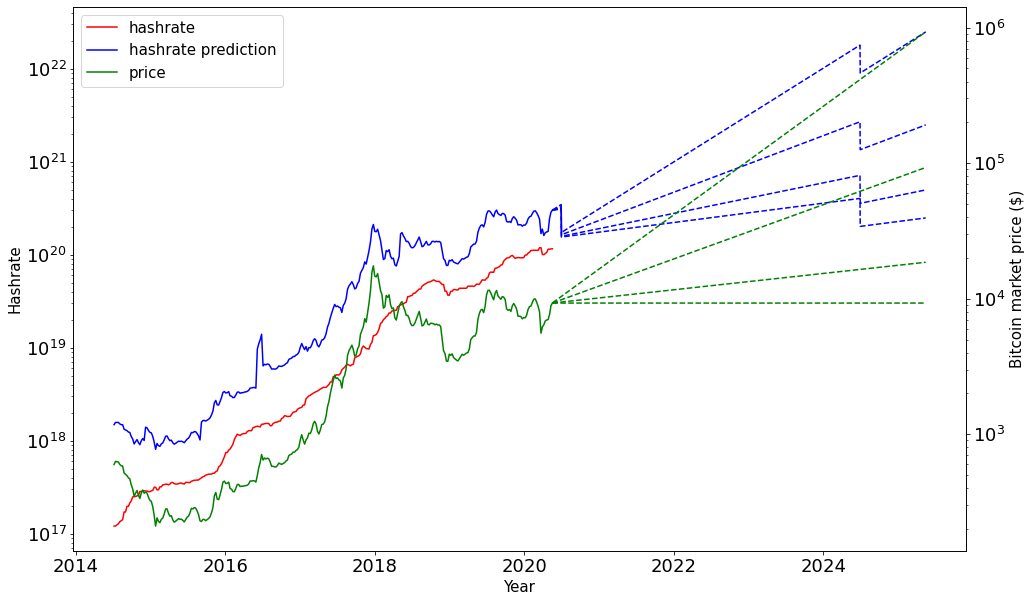

In [676]:
fig, ax1 = plt.subplots(figsize=(16,10))

# Real hashrate
ln1 = ax1.plot(bitcoin['hashrate'],color="red", label="hashrate")

# Predicted historical hashrate
bitcoin['hashrate_pred'] = bitcoin.apply(lambda x: H(x.price, x.name),axis=1)
ln2 = ax1.plot(bitcoin['hashrate_pred'], color="blue", label="hashrate prediction")

# Historical price
ax2 = ax1.twinx()
ln3 = ax2.plot(bitcoin['price'], color="green", label="price")

lines = ln1 + ln2 + ln3

# Predicted future hashrate
for x, future in futures.items():
    ax1.plot(future['time'], future['hashrate'], '--',color="blue")
    ax2.plot(future['time'], future['price'], '--', color="green")

labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc=0, fontsize=15)

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_ylabel('Hashrate', fontsize = 15)
ax2.set_ylabel('Bitcoin market price ($)', fontsize = 15)

ax1.set_xlabel('Year', fontsize = 15)

ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

plt.savefig(FIG_PATH+'BTC_hashrate_prediction.png')

plt.show()

### Electricity consumption

In [667]:
def lower_bound(date, hardware, hashrate):
    cur_hardware = hardware[hardware.release_date <= date]
    best_hardware = get_buy_hardware(cur_hardware)
    return hashrate*best_hardware['consumption']*W_to_TWh

In [668]:
bitcoin['lower_bound'] = bitcoin.apply(lambda x: lower_bound(x.name, hardware, x.hashrate_pred),axis=1)

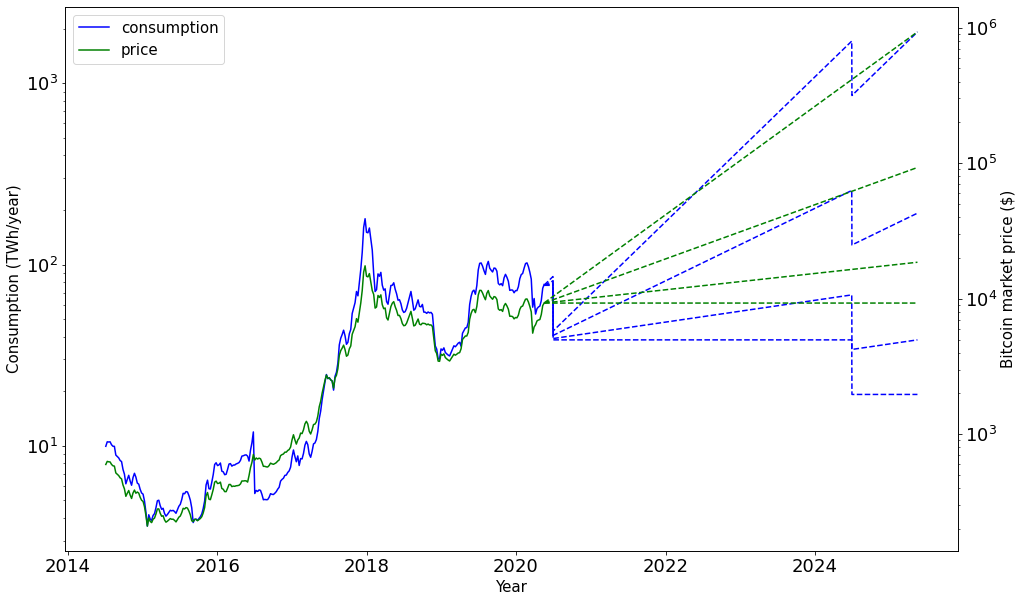

In [677]:
fig, ax1 = plt.subplots(figsize=(16,10))

ln1 = ax1.plot(bitcoin['lower_bound'],color="blue", label="consumption")


# Historical price
ax2 = ax1.twinx()
ln2 = ax2.plot(bitcoin['price'], color="green", label="price")

lines = ln1 + ln2

# Predicted future hashrate
for x, future in futures.items():
    ax1.plot(future['time'], future['consumption'], '--',color="blue")
    ax2.plot(future['time'], future['price'], '--', color="green")

labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc=0, fontsize=15)

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_ylabel('Consumption (TWh/year)', fontsize = 15)
ax2.set_ylabel('Bitcoin market price ($)', fontsize = 15)

ax1.set_xlabel('Year', fontsize = 15)

ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

plt.savefig(FIG_PATH+'BTC_consumption_prediction.png')

plt.show()

In [673]:
# Predicted future hashrate
print(1, futures[1].iloc[500]['consumption'])
for x, future in futures.items():
    print(x, future.iloc[len(future)-1]['consumption'])

1 38.41178318168988
1 19.20589159084495
2 38.41178318168991
10 192.0589159084496
100 1920.589159084495


In [701]:
prices = [0.5, 1, 2, 10, 100]
years = [1, 2, 5, 10, 20]
predictions = pd.DataFrame(index=prices,columns=years)
for x in prices:
    for t in years:
        future_hashrate, future_consumption  = predict_future(r_from_x(x,t), t)
        predictions.loc[x,t] = future_consumption
predictions.format

,1,2,5,10,20
0.5,19.2059,19.2059,9.60295,4.80147,1.20037
1.0,38.4118,38.4118,19.2059,9.60295,2.40074
2.0,76.8236,76.8236,38.4118,19.2059,4.80147
10.0,384.118,384.118,192.059,96.0295,24.0074
100.0,3841.18,3841.18,1920.59,960.295,240.074


In [704]:
pd.set_option('precision',4)
predictions

,1,2,5,10,20
0.5,19.21,19.21,9.603,4.801,1.2
1.0,38.41,38.41,19.21,9.603,2.401
2.0,76.82,76.82,38.41,19.21,4.801
10.0,384.1,384.1,192.1,96.03,24.01
100.0,3841,3841,1921,960.3,240.1


In [705]:
print(predictions.to_latex())

\begin{tabular}{llllll}
\toprule
{} &     1  &     2  &     5  &     10 &     20 \\
\midrule
0.5   &  19.21 &  19.21 &  9.603 &  4.801 &    1.2 \\
1.0   &  38.41 &  38.41 &  19.21 &  9.603 &  2.401 \\
2.0   &  76.82 &  76.82 &  38.41 &  19.21 &  4.801 \\
10.0  &  384.1 &  384.1 &  192.1 &  96.03 &  24.01 \\
100.0 &   3841 &   3841 &   1921 &  960.3 &  240.1 \\
\bottomrule
\end{tabular}



# Ethereum

In [285]:
difficulty = pd.read_csv(ETH_PATH+'difficulty.csv')
reward = pd.read_csv(ETH_PATH+'reward.csv')
price = pd.read_csv(ETH_PATH+'price.csv')

difficulty = difficulty.drop(columns='UnixTimeStamp')
difficulty.columns = ['date', 'value']
reward.columns = ['date', 'reward']
price.columns = ['date', 'price']

In [286]:
for data in [difficulty, reward, price]:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

In [287]:
difficulty = difficulty.groupby(pd.Grouper(freq='W')).mean()*10**12 # difficulty given in T per block
reward = reward.groupby(pd.Grouper(freq='W')).mean()
price = price.groupby(pd.Grouper(freq='W')).mean()
revenue = reward.join(price)
revenue['revenue'] = revenue['reward']*revenue['price']/seconds_in_day
revenue = revenue[['revenue']]

ethereum = revenue.join(difficulty)
ethereum.columns = ['revenue', 'difficulty']

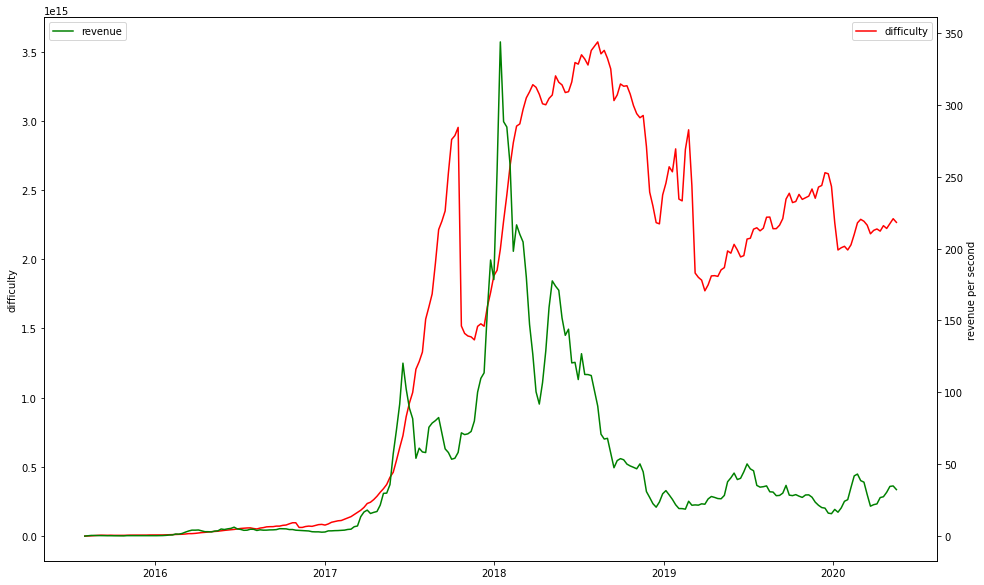

In [288]:
fig, ax1 = plt.subplots(figsize=(16,10))
ax1.plot(ethereum['difficulty'],color="red", label="difficulty")
ax1.legend()
ax1.set_ylabel('difficulty')
ax2 = ax1.twinx()
ax2.plot(ethereum['revenue'], color="green", label="revenue")
ax2.legend(loc='upper left')
ax2.set_ylabel('revenue per second')
plt.show()

In [289]:
ethash_hardware = pd.read_csv(HARDWARE_PATH+'Ethash_hardware_clean.csv',index_col=0)
# Initialisation
hardware = ethash_hardware[['name', 'release_date', 'consumption', 'hashing_power']].copy()
hardware['release_date'] = pd.to_datetime(hardware['release_date'])
hardware[:4]

,name,release_date,consumption,hashing_power
0,Radeon HD 7870,2012-03-19,0.000017,10000000
1,GeForce GTX 680,2012-03-22,0.000013,15000000
2,GeForce GTX 660 Ti,2012-08-16,0.000013,12000000
3,GeForce GTX 650 Ti,2012-09-10,0.000011,10000000


In [290]:
# Select only from first hardware available in dataset
ethereum = ethereum[ethereum.index > ethash_hardware.loc[0,'release_date']]

# Difficulty to hashrate
ethereum['hashrate'] = ethereum['difficulty']*1/ETH_block_time

In [291]:
hardware['off_num'] = 0
hardware['on_num'] = 0

cur_hashrate = 0
consumption = []
for time, data in ethereum.iterrows():
    cur_hardware = hardware[hardware.release_date < time]
    hashrate_difference = data.hashrate - cur_hashrate
    
    if time.month in wet_months:
        elec_price = avg_elec_price_wet
    else:
        elec_price = avg_elec_price_dry
    
    if hashrate_difference > 0:
        # Network hashrate has increased, turn on/buy devices
        prof_hardware = get_profitable_hardware(data, cur_hardware, elec_price)
        off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
                
        while cur_hashrate < data.hashrate and (not off_hardware.empty):
            
            best_off_hardware = get_turn_on_hardware(off_hardware)
            
            # Everything gets turned on OR the part needed for hashrate difference gets turned on
            extra_hashing_power = min(best_off_hardware.off_num*best_off_hardware.hashing_power, hashrate_difference)
            
            num_to_on = extra_hashing_power/best_off_hardware.hashing_power
            
            hardware.loc[best_off_hardware.name, 'on_num'] += num_to_on
            hardware.loc[best_off_hardware.name, 'off_num'] -= num_to_on
            
            cur_hashrate += extra_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
            
        if off_hardware.empty and cur_hashrate < data.hashrate:
            # Have to buy new hardware. Buy entire difference in hashrate from get_next_hardware
            best_hardware = get_buy_hardware(prof_hardware)
            
            num_extra = np.ceil(hashrate_difference/best_hardware.hashing_power)
            
            hardware.loc[best_hardware.name, 'on_num'] += num_extra
            
            cur_hashrate += num_extra*best_hardware.hashing_power
                
    elif hashrate_difference < 0:
        # Network hashrate has decreased, turn off devices
        on_hardware = hardware[hardware['on_num'] >= 1]
        while cur_hashrate > data.hashrate:            
            worst_on_hardware = get_turn_off_hardware(on_hardware)
        
            min_hashing_power = min(worst_on_hardware.on_num*worst_on_hardware.hashing_power, -hashrate_difference)
            
            num_to_off = np.floor(min_hashing_power/worst_on_hardware.hashing_power)
            
            hardware.loc[worst_on_hardware.name, 'on_num'] -= num_to_off
            hardware.loc[worst_on_hardware.name, 'off_num'] += num_to_off
            
            cur_hashrate -= min_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            on_hardware = hardware[hardware['on_num'] >= 1]
    else:
        #print('hashrate_difference = 0')
        pass
    hardware = replace_hardware(time, data, hardware, elec_price)
    cur_hashrate = np.sum(hardware['on_num']*hardware['hashing_power'])
    consumption.append(calc_consumption(hardware)*W_to_TWh)  

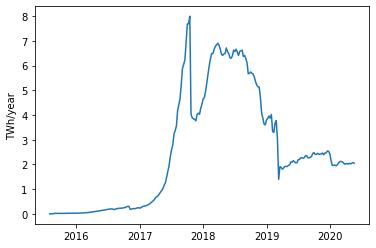

In [292]:
plt.plot(ethereum.index,consumption)
plt.ylabel('TWh/year')
plt.show()

In [293]:
hardware[(hardware['on_num'] > 0) | (hardware['off_num'] > 0)]

,name,release_date,consumption,hashing_power,off_num,on_num
17,GeForce GTX Titan X,2015-03-17,0.000006,40000000,1.615800e+04,0.000000
27,Radeon Rx 480,2016-01-06,0.000006,25000000,1.660921e+05,-0.142857
28,GeForce GTX 1070,2016-10-06,0.000005,30000000,1.996513e+05,-0.306349
31,GeForce GTX 1060,2016-08-18,0.000005,24000000,6.820200e+04,0.000000
37,Radeon RX 550,2017-04-20,0.000005,11000000,1.912686e+07,-0.610390
42,GeForce GTX 1070 Ti,2017-02-11,0.000005,32000000,3.534230e+05,0.000000
43,GTX Titan V,2017-12-13,0.000003,77000000,3.076347e+06,0.622758
44,Innosilicon A10 ETHMaster 500Mh,2019-09-01,0.000002,500000000,0.000000e+00,243406.000000
45,Innosilicon A10 ETHMaster 485Mh,2018-09-01,0.000002,485000000,2.873302e+05,60575.849975


In [294]:
ethereum.iloc[len(ethereum)-1]

revenue       3.235190e+01
difficulty    2.266229e+15
hashrate      1.510819e+14
Name: 2020-05-17 00:00:00, dtype: float64

In [295]:
np.sum(hardware['on_num']*hardware['hashing_power'])

151082315714285.72